## This version is an update to #11 but includes additional components from the AC Becker debrief (sum bases to zero, etc.)

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

In [2]:
x = np.arange(-16, 16, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
grid = np.dstack((y0, x0))
print x0.shape

(32, 32)


In [3]:
import scipy.stats

## see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html

def gaussian2d(grid, m=None, s=None):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    var = scipy.stats.multivariate_normal(mean=m, cov=cov)
    return var.pdf(grid)

#g1 = gaussian2d(grid) + gaussian2d(grid, [5,5], [3,1])
#plt.imshow(g1)

## Update: it looks like the actual code in the stack uses chebyshev1 polynomials!

Note these are essentially the same but with different scale factors.

In [4]:
# This code works, but I think the next cell is faster.
from numpy.polynomial.chebyshev import chebgrid2d

h0 = chebgrid2d(x, y, c=[[1, 0, 0], [1, 0, 0]])
h1 = chebgrid2d(x, y, c=[[0, 1, 0], [0, 1, 0]])
h2 = chebgrid2d(x, y, c=[[1, 0, 0], [0, 1, 0]])
h3 = chebgrid2d(x, y, c=[[0, 1, 0], [0, 0, 1]])

In [5]:
from numpy.polynomial.chebyshev import chebval2d
h0 = chebval2d(x0, y0, c=[[1, 0, 0], [1, 0, 0]])
h1 = chebval2d(x0, y0, c=[[0, 1, 0], [0, 1, 0]])
h2 = chebval2d(x0, y0, c=[[1, 0, 0], [0, 1, 0]])
h3 = chebval2d(x0, y0, c=[[0, 1, 0], [0, 0, 1]])

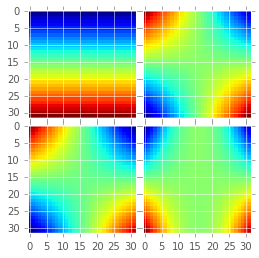

In [6]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1, (4., 4.))
igrid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
igrid[0].imshow(h0, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[1].imshow(h1, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[2].imshow(h2, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[3].imshow(h3, interpolation='none')  # The AxesGrid object work as a list of axes.

In [7]:
## The following code does exactly the same as the above:
from numpy.polynomial.chebyshev import chebval
def chebval2d_try(x, y, xord, yord):
    cx = chebval(x, xord)
    cy = chebval(y, yord)
    h0 = np.outer(cx, cy)
    return h0

if False:
    #h0 = chebval2d_try(x, y, [1, 0, 0], [0, 1, 0])
    h0 = chebval2d_try(x, y, [0, 1, 0], [0, 1, 0])
    #h0 = chebval2d_try(x, y, [0, 1, 0], [0, 0, 1])
    print h0.shape
    plt.imshow(h0)

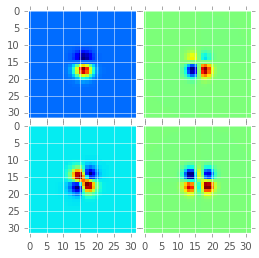

In [8]:
gh0 = gaussian2d(grid, s=[3., 3.]) * h0
gh1 = gaussian2d(grid, s=[3., 3.]) * h1
gh2 = gaussian2d(grid, s=[3., 3.]) * h2
gh3 = gaussian2d(grid, s=[3., 3.]) * h3
fig = plt.figure(1, (4., 4.))
igrid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
extent = (x0.min(), x0.max(), y0.min(), y0.max())
igrid[0].imshow(gh0, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[1].imshow(gh1, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[2].imshow(gh2, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[3].imshow(gh3, interpolation='none')  # The AxesGrid object work as a list of axes.

## Generate AL basis funcs now...

use same parameters as from the stack.

TBD: is a degGauss of 2 mean it goes up to order 2 (i.e. $x^2$)? Or is it 2 orders so it only goes up to linear ($x$)? Probably the former, so that's what we'll use.

In [9]:
# Parameters from stack
# betaGauss is actually the scale factor for sigGauss -> sigGauss[0] = sigGauss[1]/betaGauss and
#   sigGauss[2] = sigGauss[1] * betaGauss. Looks like here, betaGauss is 2 (see sigGauss below) but
#   we'll just set it to 1.
# Note should rescale sigGauss so sigGauss[1] = sqrt(sigma_I^2 - sigma_T^2)
betaGauss = 1   # in the Becker et al. paper betaGauss is 1 but PSF is more like 2 pixels?
sigGauss = [0.75, 1.5, 3.0]
degGauss = [4, 2, 2]
# Parameters from and Becker et al. (2012)
#sigGauss = [0.75, 1.5, 3.0]
#degGauss = [6, 4, 2]

## Here beta is a rescale factor but this is NOT what it is really used for.
# Can be used to rescale so that sigGauss[1] = sqrt(sigmaPsf_I^2 - sigmaPsf_T^2)
def chebGauss2d(x, y, grid, m=None, s=None, ord=[0,0], beta=1., verbose=False):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    coefLen = np.max(ord)+1
    coef0 = np.zeros(coefLen)
    coef0[ord[0]] = 1
    coef1 = np.zeros(coefLen)
    coef1[ord[1]] = 1
    if verbose:
        print s, ord, coef0, coef1
    ga = gaussian2d(grid, m, np.array(s)/beta)
    ch = chebval2d(x, y, c=np.outer(coef0, coef1))
    return ch * ga

In [10]:
basis = [chebGauss2d(x0, y0, grid, m=[0,0], s=[sig0,sig1], ord=[deg0,deg1], beta=betaGauss, verbose=True) for i0,sig0 in enumerate(sigGauss) for i1,sig1 in enumerate(sigGauss) for deg0 in range(degGauss[i0]) for deg1 in range(degGauss[i1])]
print len(basis), basis[0].shape, x0.shape, grid.shape, basis[0].reshape(x0.shape).shape

[0.75, 0.75] [0, 0] [ 1.] [ 1.]
[0.75, 0.75] [0, 1] [ 1.  0.] [ 0.  1.]
[0.75, 0.75] [0, 2] [ 1.  0.  0.] [ 0.  0.  1.]
[0.75, 0.75] [0, 3] [ 1.  0.  0.  0.] [ 0.  0.  0.  1.]
[0.75, 0.75] [1, 0] [ 0.  1.] [ 1.  0.]
[0.75, 0.75] [1, 1] [ 0.  1.] [ 0.  1.]
[0.75, 0.75] [1, 2] [ 0.  1.  0.] [ 0.  0.  1.]
[0.75, 0.75] [1, 3] [ 0.  1.  0.  0.] [ 0.  0.  0.  1.]
[0.75, 0.75] [2, 0] [ 0.  0.  1.] [ 1.  0.  0.]
[0.75, 0.75] [2, 1] [ 0.  0.  1.] [ 0.  1.  0.]
[0.75, 0.75] [2, 2] [ 0.  0.  1.] [ 0.  0.  1.]
[0.75, 0.75] [2, 3] [ 0.  0.  1.  0.] [ 0.  0.  0.  1.]
[0.75, 0.75] [3, 0] [ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[0.75, 0.75] [3, 1] [ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[0.75, 0.75] [3, 2] [ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[0.75, 0.75] [3, 3] [ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[0.75, 1.5] [0, 0] [ 1.] [ 1.]
[0.75, 1.5] [0, 1] [ 1.  0.] [ 0.  1.]
[0.75, 1.5] [1, 0] [ 0.  1.] [ 1.  0.]
[0.75, 1.5] [1, 1] [ 0.  1.] [ 0.  1.]
[0.75, 1.5] [2, 0] [ 0.  0.  1.] [ 1.  0.  0.]
[0.75, 1.5] [2, 1] [ 

Make the two "images". `im1` is the template, `im2` is the science image.

NOTE: having sources near the edges really messes up the fitting (probably because of the convolution). So make sure no sources are near the edge.

NOTE: also it seems that having the variable source with a large flux increase also messes up the fitting (seems to lead to overfitting -- perhaps to the source itself). This might be fixed by adding more constant sources.

(512,)
280 4.81591183536 -5.87310921947
1.50996688705
(512, 512)
DescribeResult(nobs=262144, minmax=(-1554.0312141521122, 560.4141139522095), mean=10.000016292477941, variance=3439.3551258435214, skewness=-8.465003825845413, kurtosis=119.25460230168227)


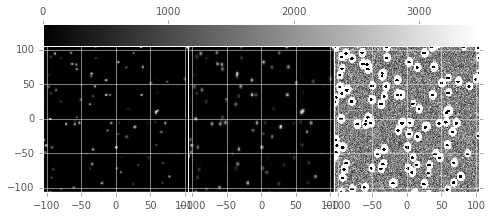

In [11]:
np.random.seed(66)

xim = np.arange(-256, 256, 1)
print xim.shape
yim = xim.copy()
y0im, x0im = np.meshgrid(xim, yim)
imgrid = np.dstack((y0im, x0im))
n_sources = 500
fluxes = np.random.uniform(50, 30000, n_sources)
xposns = np.random.uniform(xim.min()+16, xim.max()-5, n_sources)
yposns = np.random.uniform(yim.min()+16, yim.max()-5, n_sources)

# Make the source closest to the center of the image the one that increases in flux
ind = np.argmin(xposns**2. + yposns**2.)
print ind, xposns[ind], yposns[ind]

sig1 = 0.2  # sigma of template
sig2 = 0.2  # sigma of science image
im1 = np.random.normal(scale=sig1, size=x0im.shape)
im2 = np.random.normal(scale=sig2, size=x0im.shape)

psf1 = 1.6 # sigma in pixels im1 will be template
psf2 = 2.2 # sigma in pixels im2 will be science image. make the psf in this image slighly offset and elongated
print np.sqrt(psf2**2 - psf1**2)
offset = 0.2  # astrometric offset (pixels) between the two images
psf2_yvary = (yposns - yim.mean()) / yim.max() * 2.0  # variation in y-width of psf in science image across (x-dim of) image
psf2_yvary[:] = 1.1  # turn it off for now, just add a constant 1.1 pixel horizontal width

for i in range(n_sources):
    im1 += fluxes[i] * gaussian2d(imgrid, m=[xposns[i], yposns[i]], s=[psf1, psf1])
    im2 += fluxes[i] * gaussian2d(imgrid, m=[xposns[i]+offset, yposns[i]+offset], s=[psf2, psf2+psf2_yvary[i]])
    if i == ind:
        im2 += (fluxes[i]/50.) * gaussian2d(imgrid, m=[xposns[i]+offset,yposns[i]+offset], s=[psf2, psf2+psf2_yvary[i]])

fig = plt.figure(1, (9, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow((im2-im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-1,1))
igrid.cbar_axes[0].colorbar(gim)

# Add a (constant, for now) background offset to im2
im2background = 10.
im2 += im2background

print im1.shape
print scipy.stats.describe(im2 - im1, axis=None)

Convolve im1 (template) with the basis functions, and make these the *new* bases.

In [12]:
# make mean of all but first basis be zero
#for i in range(1, len(basis)):
#    basis[i] -= basis[i].mean()

In [13]:
import scipy.signal

#basis2 = [scipy.signal.fftconvolve(im1, b, mode='same') for b in basis]
basis2 = [scipy.ndimage.filters.convolve(im1, b, mode='constant') for b in basis]

print len(basis2), basis2[0].shape

64 (512, 512)


64 256
[0, 0] [ 1.] [ 1.]
[0, 1] [ 1.  0.] [ 0.  1.]
[0, 2] [ 1.  0.  0.] [ 0.  0.  1.]
[1, 0] [ 0.  1.] [ 1.  0.]
[1, 1] [ 0.  1.] [ 0.  1.]
[1, 2] [ 0.  1.  0.] [ 0.  0.  1.]
[2, 0] [ 0.  0.  1.] [ 1.  0.  0.]
[2, 1] [ 0.  0.  1.] [ 0.  1.  0.]
[2, 2] [ 0.  0.  1.] [ 0.  0.  1.]
9 1.0


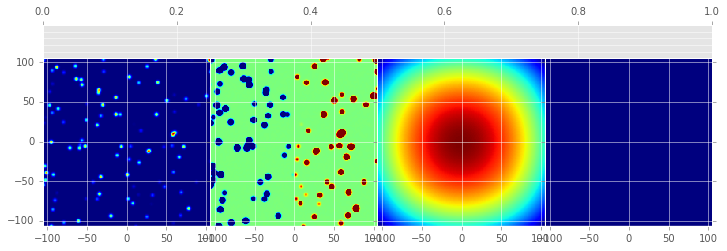

In [14]:
# Then make the spatially modified basis by simply multiplying the constant
#  basis (basis2 from above) by a polynomial along the image coordinate.
# Note that since we *are* including i=0, this new basis *does include* basis2 and
# thus can replace it.

## Here beta is a rescale factor but this is NOT what it is really used for.
# Can be used to rescale so that sigGauss[1] = sqrt(sigmaPsf_I^2 - sigmaPsf_T^2)
def cheb2d(x, y, ord=[0,0], verbose=False):
    coefLen = np.max(ord)+1
    coef0 = np.zeros(coefLen)
    coef0[ord[0]] = 1
    coef1 = np.zeros(coefLen)
    coef1[ord[1]] = 1
    if verbose:
        print ord, coef0, coef1
    ch = chebval2d(x, y, c=np.outer(coef0, coef1))
    return ch

basis2m = bgBasis = None

spatialKernelOrder = np.array([1, 1]) #np.array([0, 0])

# Note the ordering of the loop is important! Make the basis2 the last one so the first set of values
# that are returned are all of the original (basis2) unmodified bases.
if spatialKernelOrder.sum() > 0:
    xx = (x0im - np.mean(x0im))/np.max(np.abs(x0im))
    yy = (y0im - np.mean(y0im))/np.max(np.abs(y0im))
    #basis2m1 = [b * xx**xi * yy**yi for b in basis2 for xi in range(0, spatialKernelOrder[0]+1) for yi in range(0, spatialKernelOrder[1]+1-xi)]
    basis2m = [b * cheb2d(xx, yy, ord=[xi, yi], verbose=False) for xi in range(0, spatialKernelOrder[0]+1) for yi in range(0, spatialKernelOrder[1]+1) for b in basis2]
    print len(basis2), len(basis2m)

fig = plt.figure(1, (12, 4))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(basis2[0][x1d:x2d,y1d:y2d], origin='lower', interpolation='none', extent=extent)
#igrid[1].imshow(basis2m1[1][x1d:x2d,y1d:y2d], origin='lower', interpolation='none', extent=extent)
if basis2m is not None:
    igrid[1].imshow(basis2m[64][x1d:x2d,y1d:y2d], origin='lower', interpolation='none', extent=extent, clim=(-10,10))

spatialBackgroundOrder = np.array([2, 2])
    
# Then make the spatial background part
if spatialBackgroundOrder.sum() > 0:
    xx = (x0im - np.mean(x0im))/np.max(np.abs(x0im))
    yy = (y0im - np.mean(y0im))/np.max(np.abs(y0im))
    bgBasis = [cheb2d(xx, yy, ord=[xi, yi], verbose=True) for xi in range(0, spatialBackgroundOrder[0]+1) for yi in range(0, spatialBackgroundOrder[1]+1)]
    print len(bgBasis), bgBasis[0].mean()

igrid[2].imshow(bgBasis[8][x1d:x2d,y1d:y2d], origin='lower', interpolation='none', extent=extent)
if basis2m is not None:
    igrid[3].imshow((basis2[0]-basis2m[0])[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', extent=extent)

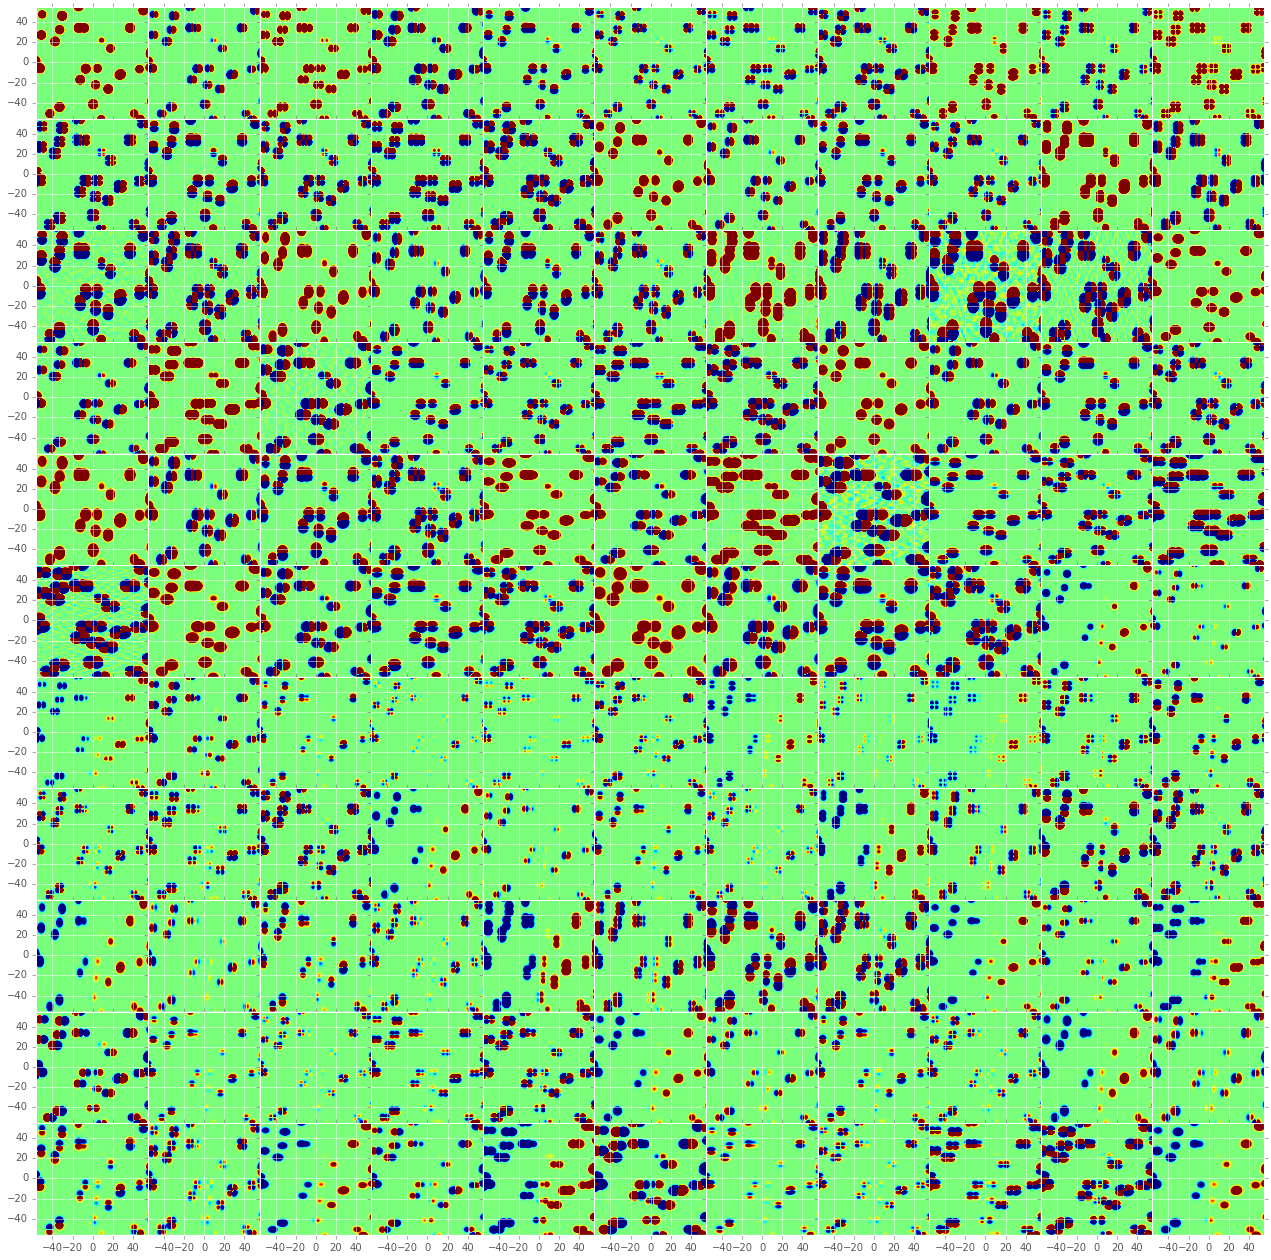

In [15]:
fig = plt.figure(1, (22., 22.))
igrid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(11, 11), axes_pad=0.0,
                    share_all=True, label_mode="L")
extent = (x0im.min()+200, x0im.max()-200, y0im.min()+200, y0im.max()-200)
x1d, x2d, y1d, y2d = 200, 512-200, 200, 512-200   # limits for display
for i in range(121):
    gim = igrid[i].imshow(basis2m[i][x1d:x2d,y1d:y2d], origin='lower', interpolation='none', extent=extent, clim=(-10,10))

In [16]:
basis2a = np.vstack([b.flatten() for b in basis2]).T
print basis2a.shape, im2.flatten().shape

constKernelIndices = np.arange(0, basis2a.shape[1])
print constKernelIndices

nonConstKernelIndices = None
if basis2m is not None:
    b1 = np.vstack([b.flatten() for b in basis2m]).T
    basis2a = b1  # Remember basis2m contains basis2 !!!
    nonConstKernelIndices = np.arange(constKernelIndices[-1]+1, basis2a.shape[1])
    print nonConstKernelIndices

bgIndices = None
if bgBasis is not None:
    b1 = np.vstack([b.flatten() for b in bgBasis]).T
    print b1.shape
    bgIndices = np.arange(basis2a.shape[1], basis2a.shape[1]+b1.shape[1])
    basis2a = np.hstack([basis2a, b1])
    print bgIndices

print basis2a.shape, im2.flatten().shape

#for i in range(1, basis2a.shape[1]):  # make mean of all but first basis be zero
#    basis2a[:,i] -= basis2a[:,i].mean()

(262144, 64) (262144,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
[ 64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255]
(

Do the linear fit to compute the matching kernel. The resulting fit is the matched template.

[  5.25814324e-01  -5.68740016e-01   1.07731573e-02  -6.38640005e-02
   1.79651573e-01   9.52764950e-02   1.35793737e-02  -1.21871718e-02
   5.83710770e-03   1.35665832e-02  -8.22463546e-03  -2.02520734e-03
   9.10086706e-04   1.62337485e-02  -1.07693128e-03   6.40454133e-05
   8.63891250e-01   1.73284615e-01   1.07010485e-01  -1.70539266e-01
   2.45074898e-02   7.78135350e-03   1.46509474e-03   8.43846188e-03
   1.30001816e-01   5.64573381e-02   6.55819378e-03  -4.35842046e-02
  -7.13364613e-04  -4.01171799e-04  -1.83392188e-05   3.16920418e-04
  -3.62674196e-01   6.57158897e-01   5.57666992e-02  -2.08510955e-02
  -1.22445733e-01   1.29100407e-01   2.03445255e-02  -3.86764400e-03
  -6.06982672e-03   2.20694780e-02  -1.39656902e-02  -2.93832785e-03
  -9.80641813e-02  -2.64436774e-02  -2.32126929e-03  -2.49823965e-03
  -2.57021810e-01   9.13052143e-02   3.52713483e-03  -5.82613641e-04
  -1.03231494e-01   1.78077905e-02   1.41758346e-03  -1.11316091e-04
   3.91459604e-03  -2.06388466e-03

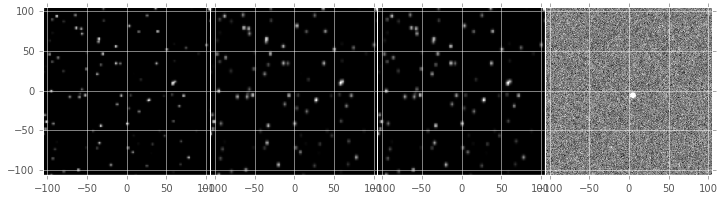

In [17]:
pars, resid, _, _ = np.linalg.lstsq(basis2a, im2.flatten())
print pars[constKernelIndices]
if nonConstKernelIndices is not None:
    print pars[nonConstKernelIndices]
if bgIndices is not None:
    print pars[bgIndices]
fit = (pars * basis2a).sum(1).reshape(im2.shape)
print resid, np.sum((im2 - fit.reshape(im2.shape))**2), np.sum((im2 - im1)**2)
print basis2a.shape, fit.shape

fig = plt.figure(1, (12, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(fit[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[3].imshow((im2 - fit)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-1,1))
#igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im2 - fit, axis=None)

Look at the resulting matching kernel by multiplying the fitted parameters times the original basis funcs. and test that actually convolving it with the template gives us a good subtraction.

(265,) (1024, 64)
0.999996059839
(32, 32)


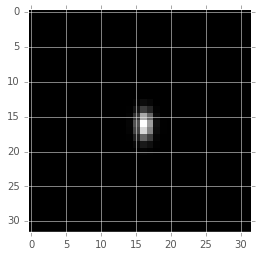

In [18]:
kbasis = np.vstack([b.flatten() for b in basis]).T
print pars.shape, kbasis.shape
kfit = (pars[constKernelIndices] * kbasis).sum(1).reshape(basis[0].shape)
print kfit.sum()
#kfit /= kfit.sum()  # this is necessary if the variable source changes a lot - prevent the kernel from incorporating that change in flux
plt.imshow(kfit, interpolation='none', cmap='gray')  # this plots the matching kernel
print kfit.shape

Compare the convolved template to the science image. Also plot the new diffim for comparison.

DescribeResult(nobs=262144, minmax=(9.066200926954755, 18.653694044887231), mean=10.000137573602052, variance=0.045727008827334673, skewness=1.5622098041763508, kurtosis=49.17957716823066)


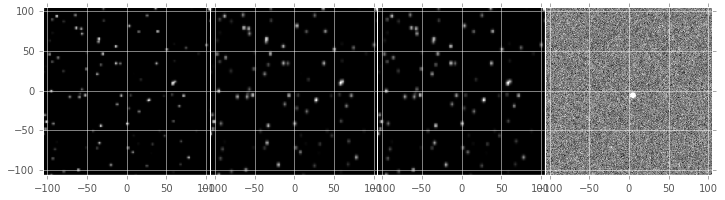

In [19]:
conv_im1 = scipy.ndimage.filters.convolve(im1, kfit, mode='constant')
fig = plt.figure(1, (12, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # original template (red)
igrid[1].imshow(conv_im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # convolved template (blue)
igrid[2].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # science image (dotted, purple)
igrid[3].imshow((im2 - conv_im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(im2background-1,im2background+1)) # diffim (grey)
print scipy.stats.describe(im2 - conv_im1, axis=None)

Create the $b_i$ and $M_{ij}$ from the A&L (1998) and Becker (2012) papers. This was done wrong in the previous version of notebook 3 (and above), although it gives identical results.

(265,)
(265, 265)
[  5.25844803e-01  -5.70537647e-01   1.07744831e-02  -6.38877823e-02
   1.80624863e-01   9.49897261e-02   1.36653285e-02  -1.22152035e-02
   5.83889021e-03   1.34104610e-02  -8.22475467e-03  -2.02476513e-03
   9.21930596e-04   1.62398431e-02  -1.07718248e-03   6.40726538e-05
   8.63876077e-01   1.74477308e-01   1.06856162e-01  -1.70613297e-01
   2.45095487e-02   7.61993808e-03   1.47056793e-03   8.44107901e-03
   1.29990994e-01   5.72226634e-02   6.52871302e-03  -4.35969551e-02
  -7.13187621e-04  -4.13259518e-04  -1.81336000e-05   3.17001538e-04
  -3.62688084e-01   6.57470014e-01   5.57675318e-02  -2.08618453e-02
  -1.23100158e-01   1.29448022e-01   2.04332223e-02  -3.88081939e-03
  -6.06744448e-03   2.20436711e-02  -1.39552060e-02  -2.93995235e-03
  -9.80636118e-02  -2.64370722e-02  -2.32234580e-03  -2.49824073e-03
  -2.57023426e-01   9.13602503e-02   3.52714769e-03  -5.83001615e-04
  -1.03652452e-01   1.78826620e-02   1.42419381e-03  -1.11832147e-04
   3.91510083e-0

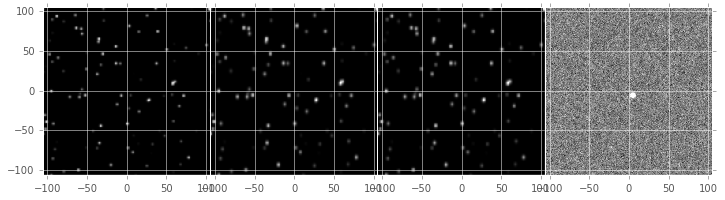

In [20]:
b = (basis2a.T * im2.flatten()).sum(1)
print b.shape

M = np.dot(basis2a.T, basis2a)
print M.shape

pars2, resid, _, _ = np.linalg.lstsq(M, b)
print pars2[constKernelIndices]
if nonConstKernelIndices is not None:
    print pars2[nonConstKernelIndices]
if bgIndices is not None:
    print pars2[bgIndices]

#print 'Difference (log10):\n', np.log10(np.abs((pars2-pars)/pars2))

fit2 = (pars2 * basis2a).sum(1).reshape(im1.shape)
print basis2a.shape, fit2.shape

fig = plt.figure(1, (12, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(fit2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[3].imshow((im2 - fit2)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-1,1))
#igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im2 - fit2, axis=None)
#print pars2-pars

(265,) (1024, 64)
0.999996059634


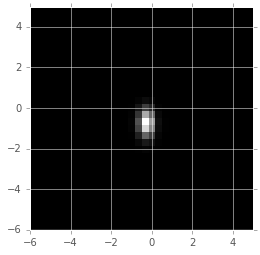

In [21]:
kbasis = np.vstack([b.flatten() for b in basis]).T
print pars2.shape, kbasis.shape
kfit2 = (pars2[constKernelIndices] * kbasis).sum(1).reshape(basis[0].shape)
print kfit2.sum()
kfit2 /= kfit2.sum()  # this is necessary if the variable source changes a lot - prevent the kernel from incorporating that change in flux
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
plt.imshow(kfit2, extent=extent, interpolation='none', cmap='gray')  # this plots the matching kernel

(512, 512) -0.241405321406 2298.4908269
DescribeResult(nobs=262144, minmax=(4.7009566453195912e-06, 2415013.0145590878), mean=3539.3423315947512, variance=1367413666.0444169, skewness=20.919884446097697, kurtosis=572.9845861862032)
DescribeResult(nobs=262144, minmax=(82.195936430027345, 347.89491223417565), mean=100.04626472964506, variance=19.008665453984531, skewness=3.6267152811053145, kurtosis=158.47913585523855)
DescribeResult(nobs=262144, minmax=(9.0661974625543724, 18.651941245730313), mean=10.000026877457735, variance=0.04572735420393275, skewness=1.561326784843123, kurtosis=49.142954541877714)


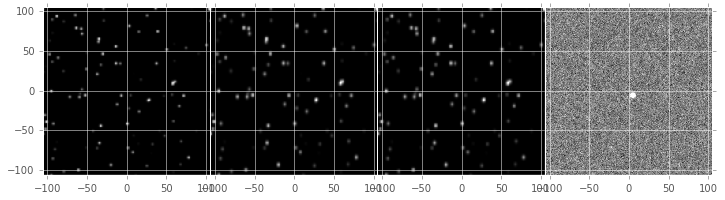

In [22]:
conv_im1 = scipy.ndimage.filters.convolve(im1, kfit2, mode='constant')
print conv_im1.shape, conv_im1.min(), conv_im1.max()
print scipy.stats.describe((im2 - im1)**2, axis=None)
print scipy.stats.describe((im2 - conv_im1)**2, axis=None)

fig = plt.figure(1, (12, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # original template (red)
igrid[1].imshow(conv_im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # convolved template (blue)
igrid[2].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # science image (dotted, purple)
igrid[3].imshow((im2 - conv_im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(9,11)) # diffim (grey)
print scipy.stats.describe(im2 - conv_im1, axis=None)

Add taking into account PSF variations... (next notebook, #4)

## Compute the "L(ZOGY)" post-conv. kernel from kfit

(32, 32) (32, 32)
1.37505930841
-0.0372565132645
1.00000197008
(16, 16)


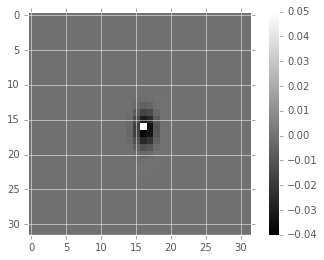

In [23]:
from scipy.fftpack import fft2, ifft2, fftfreq, fftshift

def kernel_ft2(kernel):
    FFT = fft2(kernel)
    return FFT
def post_conv_kernel_ft2(kernel, sig1=1., sig2=1.):
    kft = kernel_ft2(kernel)
    return np.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kft**2))
def post_conv_kernel2(kernel, sig1=1., sig2=1.):
    kft = post_conv_kernel_ft2(kernel, sig1, sig2)
    out = ifft2(kft)
    return out

pck = post_conv_kernel2(kfit, sig1=sig2, sig2=sig1)
print kfit.shape, pck.real.shape
print pck.real.max()
print pck.real.min()
print pck.real.sum()
pck = np.fft.ifftshift(pck.real)
print np.unravel_index(np.argmax(pck), pck.shape)
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
plt.imshow(pck, interpolation='none', cmap='gray', clim=(-0.04,0.05))  # this plots the matching kernel
plt.colorbar()

### I think we actually need to "reverse" the PSF, as in the ZOGY (and Kaiser) papers... let's try it.

This is the same as taking the complex conjugate in Fourier space before FFT-ing back to real space.

In [24]:
def post_conv_kernel2a(kernel, sig1=1., sig2=1.):
    kft = post_conv_kernel_ft2(kernel, sig1, sig2)
    kft = np.conj(kft)
    out = ifft2(kft)
    return out

if False:
    pck = post_conv_kernel2a(kfit, sig1=sig2, sig2=sig1)
    print pck.real.max()
    print pck.real.min()
    print pck.real.sum()
    pck = np.fft.ifftshift(pck.real)

    # I still think we need to flip it in one axis (TBD: figure this out!)
    pck = pck[::-1,:]

    extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
    plt.imshow(pck, extent=extent, interpolation='none', cmap='gray', clim=(-0.04,0.05))  # this plots the matching kernel
    plt.colorbar()

## Now convolve the image difference with the kernel.

1.00000197008 1.37505930841 -0.0372565132645
DescribeResult(nobs=262144, minmax=(8.6850602995440642, 19.951376371419517), mean=10.014851330174892, variance=0.10204461096897478, skewness=1.4769956201954761, kurtosis=19.741411176332655)
DescribeResult(nobs=262144, minmax=(9.0661974625543724, 18.651941245730313), mean=10.000026877457735, variance=0.04572735420393275, skewness=1.561326784843123, kurtosis=49.142954541877714)


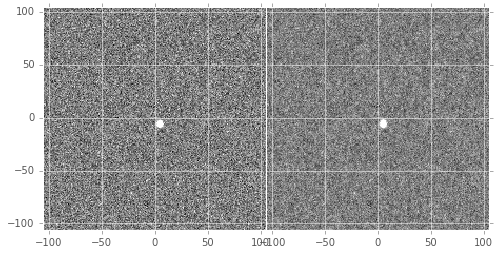

In [25]:
print pck.sum(), pck.max(), pck.min()
#pck /= pck.sum()
pci = scipy.ndimage.filters.convolve(im2-conv_im1, pck, mode='constant')

fig = plt.figure(1, (8, 4))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(pci[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(im2background-1,im2background+1)) # corrected diffim
igrid[1].imshow((im2 - conv_im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(im2background-1,im2background+1)) # original diffim
print scipy.stats.describe(pci, axis=None)
print scipy.stats.describe(im2 - conv_im1, axis=None)

9.00022173944 11.0032402549
Corrected: 10.0039495866 0.286888114731
Original:  9.99911965865 0.207240766751
Expected:  0.282842712475


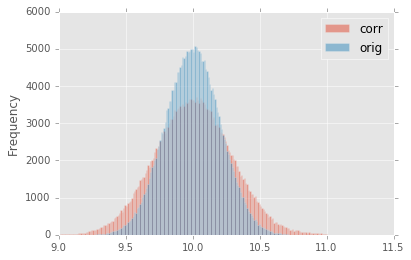

In [26]:
import pandas as pd
#df = pd.DataFrame({'corr': pci.flatten(), 'orig': (im2-conv_im1).flatten()})
#df.plot.hist(alpha=0.5, bins=200)

_, low, upp = scipy.stats.sigmaclip([pci, im2-conv_im1])
print low, upp
tmp1a = pci[(pci>low) & (pci<upp) & (im2-conv_im1>low) & (im2-conv_im1<upp)]
tmp2a = (im2-conv_im1)[(pci>low) & (pci<upp) & (im2-conv_im1>low) & (im2-conv_im1<upp)]
df = pd.DataFrame({'corr': tmp1a.flatten(), 'orig': tmp2a.flatten()})
df.plot.hist(alpha=0.5, bins=200)

print 'Corrected:', np.mean(tmp1a), np.std(tmp1a)
print 'Original: ', np.mean(tmp2a), np.std(tmp2a)
print 'Expected: ', np.sqrt(sig1**2 + sig2**2)

## Compute the (corrected) diffim's new PSF

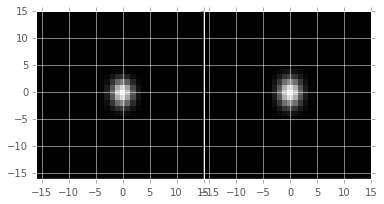

In [27]:
# post_conv_psf = phi_1(k) * sym.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kappa_ft(k)**2))
# we'll parameterize phi_1(k) as a gaussian with sigma "psfsig1".

def kernel_ft2(kernel):
    FFT = fft2(kernel)
    return FFT
def post_conv_psf_ft2(psf, kernel, sig1=1., sig2=1.):
    psf_ft = kernel_ft2(psf)
    kft = kernel_ft2(kernel)
    out = psf_ft * np.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kft**2))
    return out
def post_conv_psf(psf, kernel, sig1=1., sig2=1.):
    kft = post_conv_psf_ft2(psf, kernel, sig1, sig2)
    out = ifft2(kft)
    return out

# First compute the science image's (im2's) psf -- easy since we parameterized it above when we made the image
im2_psf = gaussian2d(grid, m=[0, 0], s=[psf2, psf2*1.5])

pcf = post_conv_psf(psf=im2_psf, kernel=kfit, sig1=sig2, sig2=sig1)
pcf = pcf.real / pcf.real.sum()

fig = plt.figure(1, (6, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.0)
extent = (x0.min(), x0.max(), y0.min(), y0.max())
gim = igrid[0].imshow(pcf, origin='lower', interpolation='none', cmap='gray', extent=extent) #, clim=(-0.01,0.01)) # corrected psf
igrid[1].imshow(im2_psf, origin='lower', interpolation='none', cmap='gray', extent=extent) #, clim=(-0.01,0.01)) # original psf

Look at how detection would compare in the new diffim vs. the original one by convolving them with their psfs.

In [28]:
tmp1 = scipy.ndimage.filters.convolve(pci, pcf, mode='constant')
#plt.plot(xim, tmp1)  # red - corrected
tmp2 = scipy.ndimage.filters.convolve(im2-conv_im1, im2_psf, mode='constant')
#plt.plot(xim, tmp2)  # blue - original

Detect 5-$\sigma$ sources. First compute stats on the convolved diffim's.

9.80020724955 10.1987786903
1.55561592485 1.8835866515
262144 262144
0.269037189373 0.2276222764
1: 262144 -256 255 9.96549633251 4.10765970023 15.2773918651
2: 262144 -256 255 9.95032565861 3.83165446865 14.4104031291


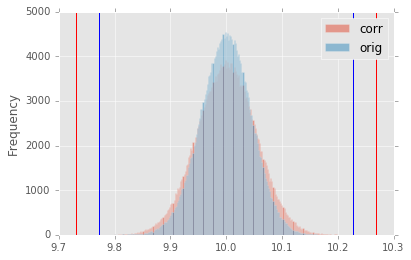

In [29]:
#df = pd.DataFrame({'corr': tmp1.flatten(), 'orig': tmp2.flatten()})
#df.plot.hist(alpha=0.5, bins=200)

_, low, upp = scipy.stats.sigmaclip([tmp1, tmp2])
print low, upp
tmp1a = tmp1[(tmp1>low) & (tmp1<upp) & (tmp2>low) & (tmp2<upp)]
tmp2a = tmp2[(tmp1>low) & (tmp1<upp) & (tmp2>low) & (tmp2<upp)]
df = pd.DataFrame({'corr': tmp1a.flatten(), 'orig': tmp2a.flatten()})
df.plot.hist(alpha=0.5, bins=200)

print tmp1.std()*5., tmp2.std()*5.
print np.sum(np.abs(tmp1) > tmp1.std()*5.), np.sum(np.abs(tmp2) > tmp2.std()*5.)

import scipy.stats
tmp1a, low, upp = scipy.stats.sigmaclip(tmp1)
tmp2a, low, upp = scipy.stats.sigmaclip(tmp2)
print tmp1a.std()*5., tmp2a.std()*5.

det1 = x0im[np.abs(tmp1) > tmp1a.std()*5.]
src1 = tmp1[np.abs(tmp1) > tmp1a.std()*5.]
det2 = x0im[np.abs(tmp2) > tmp2a.std()*5.]
src2 = tmp2[np.abs(tmp2) > tmp2a.std()*5.]
if len(det1) > 0: 
    print '1:', len(det1), det1.min(), det1.max(), src1.mean(), src1.min(), src1.max()
else:
    print '1:', len(det1)
    
if len(det2) > 0:
    print '2:', len(det2), det2.min(), det2.max(), src2.mean(), src2.min(), src2.max()
else:
    print '2:', len(det2)

xaxs = np.linspace(df.min()[0], df.max()[0])
#plt.plot(xaxs, 200*gaussian(xaxs, s=tmp1a.std()), color='r')
#plt.plot(xaxs, 200*gaussian(xaxs, s=tmp2a.std()), color='b')
plt.plot(tmp1a.mean()+np.repeat(tmp1a.std()*5., 2), [-0, 5000], color='r')
plt.plot(tmp1a.mean()-np.repeat(tmp1a.std()*5., 2), [-0, 5000], color='r')
plt.plot(tmp2a.mean()+np.repeat(tmp2a.std()*5., 2), [-0, 5000], color='b')
plt.plot(tmp2a.mean()-np.repeat(tmp2a.std()*5., 2), [-0, 5000], color='b')

Dump the results for comparison with ZOGY in notebook #13.

In [30]:
import cPickle
import gzip
im1_psf = gaussian2d(grid, m=[0, 0], s=[psf1, psf1])
cPickle.dump((im1, im2, im1_psf, im2_psf, conv_im1, pci, pcf), gzip.GzipFile("14_results.p.gz", "wb"))